In [18]:
import tensorflow as tf
import os


In [19]:
#pip install opencv-python

In [20]:
import sys
!{sys.executable} -m pip install git+https://github.com/zzh8829/yolov3-tf2.git@master

  Cloning https://github.com/zzh8829/yolov3-tf2.git (to revision master) to /private/var/folders/pk/v_whv2ks4tgbcc29klmv8m2r0000gq/T/pip-req-build-hw16gviw
  Running command git clone -q https://github.com/zzh8829/yolov3-tf2.git /private/var/folders/pk/v_whv2ks4tgbcc29klmv8m2r0000gq/T/pip-req-build-hw16gviw
  Created wheel for yolov3-tf2: filename=yolov3_tf2-0.1-py3-none-any.whl size=8831 sha256=5d7f1dae1bd4a09a621fad27ee5c39b80f4c3b8f9aba8fb1b360aef65ef71860
  Stored in directory: /private/var/folders/pk/v_whv2ks4tgbcc29klmv8m2r0000gq/T/pip-ephem-wheel-cache-x_x5utoi/wheels/43/d0/5d/3eecf5a93704dcd9672fed230139a16702c300400c79c53cb0
Successfully built yolov3-tf2


In [21]:
ROOT = os.path.join(os.getcwd())


In [22]:
filename_darknet_weights = tf.keras.utils.get_file(
    os.path.join(ROOT,'yolov3.weights'),
    origin='https://pjreddie.com/media/files/yolov3.weights')
TINY = False

filename_convert_script = tf.keras.utils.get_file(
    os.path.join(os.getcwd(),'convert.py'),
    origin='https://raw.githubusercontent.com/zzh8829/yolov3-tf2/master/convert.py')

filename_classes = tf.keras.utils.get_file(
    os.path.join(ROOT,'coco.names'),
    origin='https://raw.githubusercontent.com/zzh8829/yolov3-tf2/master/data/coco.names')
filename_converted_weights = os.path.join(ROOT,'yolov3.tf')

8192/1277 [================================================================================================================================================================================================] - 0s 0us/step


In [6]:
import sys
!{sys.executable} "{filename_convert_script}" --weights "{filename_darknet_weights}" --output "{filename_converted_weights}"

2020-05-02 19:36:01.506932: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbfaa0b3660 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-05-02 19:36:01.506958: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, None, None, 5 11024384    yol

I0502 19:36:07.282520 140735561945984 utils.py:45] yolo_conv_0/conv2d_52 bn
I0502 19:36:07.288140 140735561945984 utils.py:45] yolo_conv_0/conv2d_53 bn
I0502 19:36:07.354603 140735561945984 utils.py:45] yolo_conv_0/conv2d_54 bn
I0502 19:36:07.360774 140735561945984 utils.py:45] yolo_conv_0/conv2d_55 bn
I0502 19:36:07.427184 140735561945984 utils.py:45] yolo_conv_0/conv2d_56 bn
I0502 19:36:07.432491 140735561945984 utils.py:45] yolo_output_0/conv2d_57 bn
I0502 19:36:07.488463 140735561945984 utils.py:45] yolo_output_0/conv2d_58 bias
I0502 19:36:07.492619 140735561945984 utils.py:45] yolo_conv_1/conv2d_59 bn
I0502 19:36:07.494902 140735561945984 utils.py:45] yolo_conv_1/conv2d_60 bn
I0502 19:36:07.497442 140735561945984 utils.py:45] yolo_conv_1/conv2d_61 bn
I0502 19:36:07.508082 140735561945984 utils.py:45] yolo_conv_1/conv2d_62 bn
I0502 19:36:07.509850 140735561945984 utils.py:45] yolo_conv_1/conv2d_63 bn
I0502 19:36:07.521082 140735561945984 utils.py:45] yolo_conv_1/conv2d_64 bn
I0502 

In [8]:
#yolov3.weights - These are the pre-trained weights provided by the author of YOLO.
#convert.py - This is a Python script that converts yolov3.weights into a TensorFlow compatible weight format.
#coco.names - The names of the 80 items that the yolov3.weights neural network was trained to recognize.
#yolov3.tf - The YOLO weights converted to a format that TensorFlow can use directly.

In [9]:

import os
os.remove(filename_convert_script)

In [10]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (YoloV3, YoloV3Tiny)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
import sys
from PIL import Image, ImageFile
import requests

In [ ]:
#!!! Impoertant note below cell (related to flags can only be executed once or else it will give you error)

In [12]:
# Flags are used to define several options for YOLO.
flags.DEFINE_string('classes', filename_classes, 'path to classes file')
flags.DEFINE_string('weights', filename_converted_weights, 'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
FLAGS([sys.argv[0]])

['/opt/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py']

In [23]:
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

# Load weights and classes
yolo.load_weights(FLAGS.weights).expect_partial()
print('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
print('classes loaded')

weights loaded
classes loaded


In [24]:
#testing yolov3 on images
url = "https://raw.githubusercontent.com/smilyamit/Google_Colab/master/Amit_prague.jpg"
response = requests.get(url)
img_raw = tf.image.decode_image(response.content, channels=3)

In [26]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"
        
#Preprocess image
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

# Desired threshold (any sub-image below this confidence level will be ignored.)
FLAGS.yolo_score_threshold = 0.5

# Recognize and report results
t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
print(f"Prediction time: {hms_string(t2 - t1)}")

Prediction time: 0:00:01.12


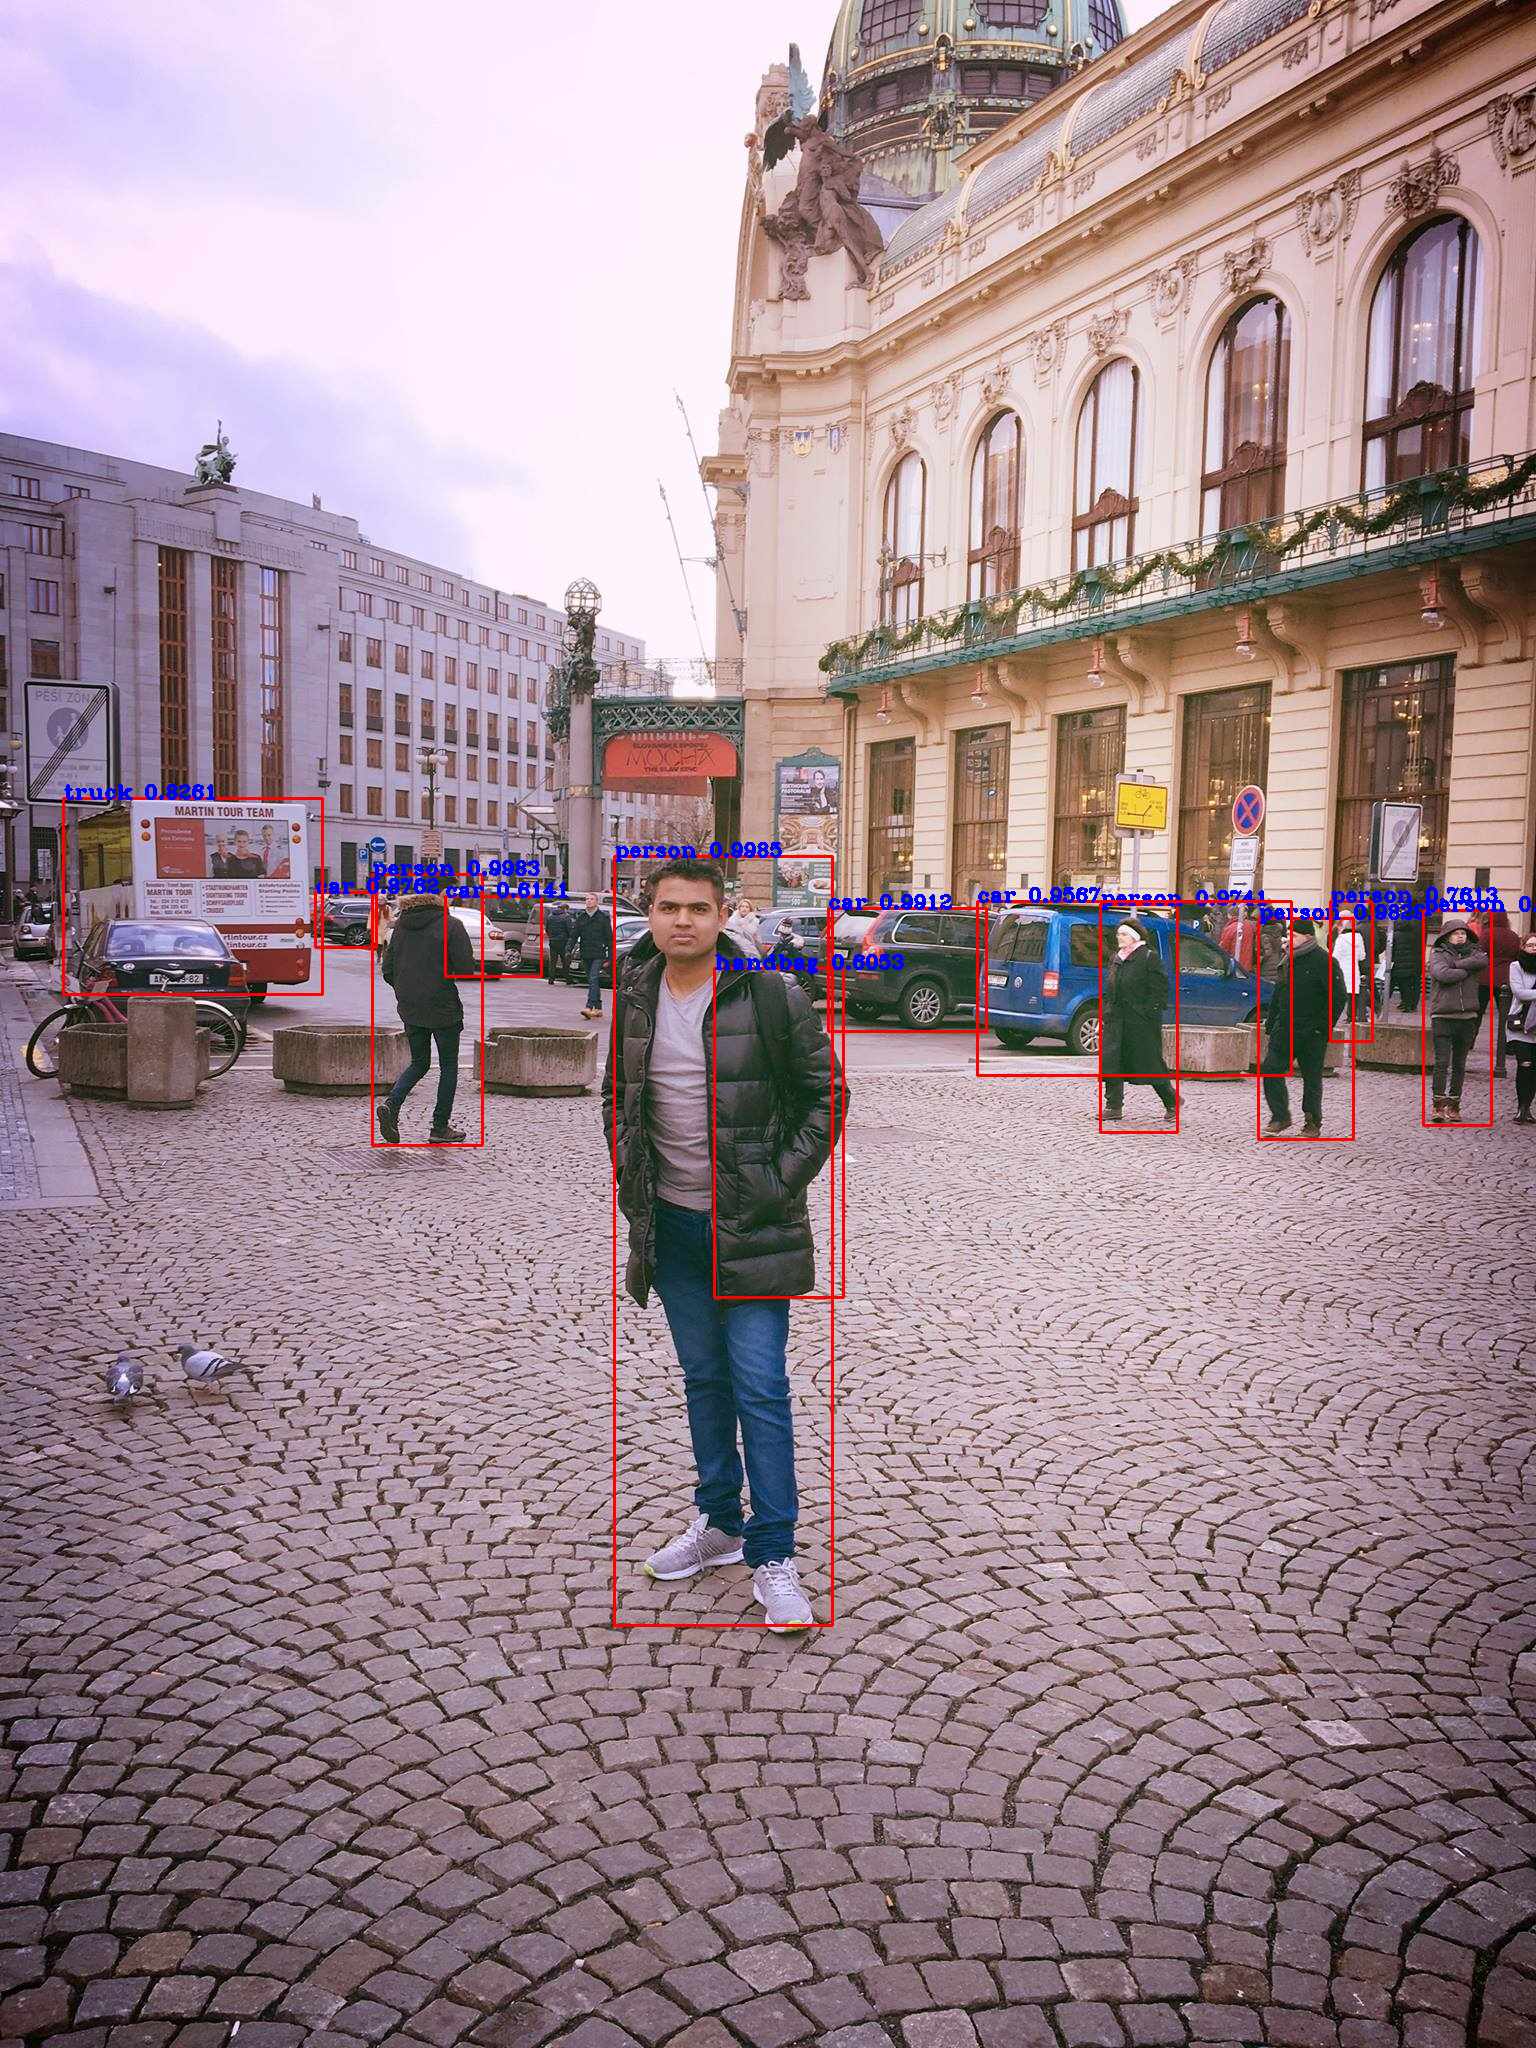

In [27]:
# Display image using YOLO library's built in function
img = img_raw.numpy()
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
#cv2.imwrite(FLAGS.output, img) # Save the image
display(Image.fromarray(img, 'RGB')) # Display the image

In [ ]:
#Below code is just extra to check the probability of each detected image

In [33]:

print('detections:')
for i in range(nums[0]):
    cls = class_names[int(classes[0][i])]
    score = np.array(scores[0][i])
    box = np.array(boxes[0][i])
    print(f"\t{cls}, {score}, {box}")

detections:
	person, 0.9985364675521851, [0.4001397  0.41818833 0.54204506 0.7938385 ]
	person, 0.9983002543449402, [0.24228363 0.42695206 0.314317   0.5592627 ]
	car, 0.991233229637146, [0.5391768  0.44357365 0.6420636  0.50346917]
	person, 0.9828878045082092, [0.81947315 0.44849712 0.88087463 0.55621225]
	person, 0.9741286635398865, [0.7162715  0.44169396 0.7665248  0.5529203 ]
	car, 0.9566545486450195, [0.6366584  0.44021463 0.8406003  0.5252044 ]
	person, 0.9292664527893066, [0.92651606 0.4446449  0.97077584 0.5496487 ]
	car, 0.8761515021324158, [0.20544875 0.4358795  0.24528494 0.46277872]
	truck, 0.8260771036148071, [0.04150324 0.38991845 0.20967075 0.48536962]
	person, 0.7612947821617126, [0.8662203  0.440275   0.8933242  0.50839543]
	car, 0.6141089200973511, [0.29001433 0.4377293  0.3522349  0.47680718]
	handbag, 0.6053121089935303, [0.46508303 0.47302163 0.5491004  0.6336473 ]


In [ ]:
#End